In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/MyDrive/Colab Notebooks/SDTRA/data/'

Mounted at /content/drive


# ***PARTE 1 - CLASSIFICAZIONE***

https://neptune.ai/blog/balanced-accuracy

In [2]:
import numpy as np
import pandas as pd
import time
import torchvision
import torch

!pip install --upgrade pytorch-pretrained-vit as ViT
!pip install torch-position-embedding
!pip install efficientnet_pytorch
!pip install densenet_pytorch

from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.decomposition import PCA


random.seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torch-position-embedding: filename=torch_position_embedding-0.8.0-py3-none-any.whl size=3425 sha256=24906ec348b04e0a1b78aed29f9b69d67a1e0e58ac0aa975e3b0e717d278b676
  Stored in directory: /root/.cache/pip/wheels/c9/23/48/d7209b26fadfe58f62735a9a8c87940716a66322d5f8805573
Successfully built torch-position-embedding
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha25

In [3]:
doPCA = False
C_score = False
M_score = True
S_score = False
E_score = False

epoch_num = 10

if C_score == True:
  batch_size = 50
  n = 20000
  tot_train = 20000 #C_score
  train_path = data_path+'train/C_score'
  val_path = data_path+'val/C_score'
  classes = ['yes', 'no']

elif E_score == True:
  batch_size = 50
  n = 20000
  tot_train = 20000 #C_score
  train_path = data_path+'train/E_score/'
  val_path = data_path+'val/E_score'
  classes = ['yes', 'no']

elif M_score == True:
  n = 30000
  batch_size = 60
  tot_train = 30000
  train_path = data_path+'train/M_score/'
  val_path = data_path+'val/M_score/'
  #classes = ['GGS', 'NoGS', 'SGS']
  classes = ['yes', 'no', 'nan']

elif S_score == True:
  n = 30000
  batch_size = 60
  tot_train = 30000
  train_path = data_path+'train/S_score/'
  val_path = data_path+'val/S_score/'
  classes = ['GGS', 'NoGS', 'SGS']

In [4]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## **DATALOADER**
Normalizzazione:
https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html#:~:text=mean%3A%20simply%20divide%20the%20sum,%2F%20count%20%2D%20total_mean%20**%202)

https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/


### Mean and Std to normalize dataset

In [5]:
def data_normalization(dataloaders, dataset):
  
        psum_train = torch.tensor([0.0, 0.0, 0.0])
        psum_sq_train = torch.tensor([0.0, 0.0, 0.0])
        psum_val = torch.tensor([0.0, 0.0, 0.0])
        psum_sq_val = torch.tensor([0.0, 0.0, 0.0])

      # loop through images
        for inputs_train, inputs_val in zip(tqdm(dataloaders['train']), tqdm(dataloaders['valid'])):
            psum_train += inputs_train[0].sum(axis=[0, 2, 3])
            psum_sq_train += (inputs_train[0]**2).sum(axis=[0, 2, 3])

            psum_val += inputs_val[0].sum(axis=[0, 2, 3])
            psum_sq_val += (inputs_val[0]**2).sum(axis=[0, 2, 3])
            
            
        image_size = dataset['train'][1][0].shape
        count_train = len(dataset["train"]) * image_size[1] * image_size[2]
        count_val = len(dataset['valid']) * image_size[1] * image_size[2]

        # mean and std for training set
        mean_train = psum_train / count_train
        total_var_t  = (psum_sq_train / count_train) - (mean_train ** 2)
        std_train  = torch.sqrt(total_var_t)
        # output
        
        print('mean (train): '  + str(mean_train))
        print('std (train):  '  + str(std_train))

        # mean and std for validation set
        mean_val = psum_val / count_val
        total_var_v  = (psum_sq_val / count_val) - (mean_val ** 2)
        std_val  = torch.sqrt(total_var_v)
        # output
        print('\n')
        print('mean (val): '  + str(mean_val))
        print('std (val):  '  + str(std_val))

        return mean_train, mean_val, std_val, std_train

In [6]:
def create_dataset( train_path, val_path, norm_val=[], norm=False):

  if norm == False:
      image_transforms = { 
        'train': transforms.Compose([
            #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            #transforms.CenterCrop(size=224),
            transforms.ToTensor()#,
        ]),
        'valid': transforms.Compose([
            #transforms.Resize(size=256),
            #transforms.CenterCrop(size=224),
            transforms.ToTensor()#, 
        ])}
  else:
    mean_train, mean_val, std_val, std_train = norm_val
    image_transforms = { 
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256),# scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_train,std_train)
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(size=256),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean_val, std_val)
    ])}

  dataset = {'train': datasets.ImageFolder(root=train_path, transform=image_transforms['train']),
            'valid': datasets.ImageFolder(root=val_path, transform=image_transforms['valid'])}

  dataloaders = {'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True,
                              pin_memory=True, drop_last=True),
                  'valid': DataLoader(dataset['valid'], batch_size=batch_size, shuffle=True,
                              pin_memory=True, drop_last=True)}
  image_size = dataset['train'][1][0].shape
  
  return dataset, dataloaders, image_size

In [7]:
dataset, dataloaders, image_size = create_dataset(train_path, val_path, norm=False)

#mean_train, mean_val, std_val, std_train = data_normalization(dataloaders, dataset)
#norm_val = [mean_train, mean_val, std_val, std_train]
#dataset, dataloaders, image_size = create_dataset( train_path, val_path, norm_val, norm=True)

dataset_sizes = {'train':len(dataset['train']),
                  'valid':len(dataset['valid'])}
n_comp = 100
if doPCA == True:
  pca = PCA(n_components=n_comp, random_state=33)
  pca.fit(dataset['train'])
  x_train = pca.transform(dataset['train'])
  x_test = pca.transform(dataset['test'])

## ***NET***
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://github.com/anilsathyan7/pytorch-image-classification/blob/4b3b1f4ba1984b6016b90844c9634f345c1e52c9/nets.py
https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## ***ALEXNET***

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*2*2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h


net = AlexNet(2)

## ***MAIN***
https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb

https://github.com/lukemelas/EfficientNet-PyTorch/tree/2eb7a7d264344ddf15d0a06ee99b0dca524c6a07

In [ ]:
LR_FIND = False
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
!pip install torch-lr-finder -v --global-option="apex"
from torch_lr_finder import LRFinder
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

if LR_FIND == True:
  #net = models.alexnet(pretrained=True)
  net = DenseNet.from_pretrained('densenet121')
  #net = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
  #
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=1e-7, weight_decay=1e-2)
  lr_finder = LRFinder(net, optimizer, criterion, device=device)
  lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
  lr_finder.plot() # to inspect the loss-learning rate graph
  lr_finder.reset() # to reset the model and optimizer to their initial state


In [8]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from densenet_pytorch import DenseNet 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

epoch_num = 7
DenseNet_cnn = True
EfficientNet_cnn = False
AlexNet_cnn = False

if EfficientNet_cnn == True:
  net = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
elif DenseNet_cnn == True:
  net = DenseNet.from_pretrained('densenet121')
elif AlexNet_cnn == True:
  net = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Loaded pretrained weights for densenet121


In [ ]:

FOUND_LR = 0.001

#alexnet.eval()

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
predicted_list = []
predicted_list_nm = []
labels_list = []
labels_list_nm =[]
score_list = []
score_list_nm = []
prob_list = []
prob_list_nm = []

count_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'The model has {count_parameters} trainable parameters')
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=FOUND_LR, weight_decay=1e-2, momentum=0.9)

for epoch in range(epoch_num):  
    start_time = time.monotonic()
    epoch_loss = 0.0
    epoch_acc = 0
    net.train()
    batch_idx = 0
    for i, data in enumerate(dataloaders['train'], 0):
        print(f"Epoch {epoch+1}/{epoch_num} - batch {batch_idx+1}/{n/batch_size}")
        batch_idx += 1

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().cpu().item()

        epoch_acc += torch.sum(preds == labels.data)

    epoch_loss = epoch_loss / dataset_sizes['train']
    epoch_acc = epoch_acc.double() / dataset_sizes['train']
    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    correct = 0
    total = 0
    valid_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
      net.eval()
      y_true = []     
      y_pred = []
      score = []
      prob = []

      for data in dataloaders['valid']:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          probs = F.softmax(outputs[:,:3], dim=1)
          # the class with the highest energy is what we choose as prediction
          scores, predicted = torch.max(outputs.data, 1)

          val_loss = criterion(outputs, labels)
          valid_loss += val_loss.detach().cpu().item()

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          y_pred.append(predicted.detach().cpu().numpy())
          y_true.append(labels.detach().cpu().numpy())
          score.append(scores.detach().cpu().numpy())
          prob.append(probs.detach().cpu().numpy())

    predicted_list_nm.append(y_pred)
    labels_list_nm.append(y_true)
    score_list_nm.append(score)
    prob_list_nm.append(prob)

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    score = np.concatenate(score, axis=0)
    prob = np.concatenate(prob, axis=0)

    predicted_list.append(y_pred)
    labels_list.append(y_true)
    score_list.append(score)
    prob_list.append(prob)

    test_acc_list.append((correct / total)*100)
    valid_size = dataset_sizes['valid']
    test_loss_list.append(valid_loss/valid_size)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss/valid_size:.3f} |  Val. Acc: {correct / total*100:.2f}%')

    #if test_acc_list[-1] > 70:
    #  torch.save(net, data_path + 'results2/S_score/'+ f'best_DenseNet_model_n{epoch}.pth')

#plt.show()
#print(f"Epoch {epoch} / {epoch_num}")  
print('Finished Training')

The model has 7978856 trainable parameters
Epoch 1/7 - batch 1/500.0
Epoch 1/7 - batch 2/500.0
Epoch 1/7 - batch 3/500.0
Epoch 1/7 - batch 4/500.0
Epoch 1/7 - batch 5/500.0
Epoch 1/7 - batch 6/500.0
Epoch 1/7 - batch 7/500.0
Epoch 1/7 - batch 8/500.0
Epoch 1/7 - batch 9/500.0
Epoch 1/7 - batch 10/500.0
Epoch 1/7 - batch 11/500.0
Epoch 1/7 - batch 12/500.0
Epoch 1/7 - batch 13/500.0
Epoch 1/7 - batch 14/500.0
Epoch 1/7 - batch 15/500.0
Epoch 1/7 - batch 16/500.0
Epoch 1/7 - batch 17/500.0
Epoch 1/7 - batch 18/500.0
Epoch 1/7 - batch 19/500.0
Epoch 1/7 - batch 20/500.0
Epoch 1/7 - batch 21/500.0
Epoch 1/7 - batch 22/500.0
Epoch 1/7 - batch 23/500.0
Epoch 1/7 - batch 24/500.0
Epoch 1/7 - batch 25/500.0
Epoch 1/7 - batch 26/500.0
Epoch 1/7 - batch 27/500.0
Epoch 1/7 - batch 28/500.0
Epoch 1/7 - batch 29/500.0
Epoch 1/7 - batch 30/500.0
Epoch 1/7 - batch 31/500.0
Epoch 1/7 - batch 32/500.0
Epoch 1/7 - batch 33/500.0
Epoch 1/7 - batch 34/500.0
Epoch 1/7 - batch 35/500.0
Epoch 1/7 - batch 36/

In [ ]:
#epoch_num = 10
test_acc_list = torch.tensor(test_acc_list, device = 'cpu')
test_loss_list =  torch.tensor(test_loss_list, device = 'cpu')
train_loss_list =  torch.tensor(train_loss_list, device = 'cpu')
train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
#print(test_loss_list)
results = pd.DataFrame({'Epoch': list(range(1,epoch_num+1)),
                     'LR': [FOUND_LR]*(epoch_num),
                     'Batch size': [batch_size]*(epoch_num),
                     'Train acc': train_acc_list,
                     'Train loss': train_loss_list,
                     'Test acc': test_acc_list,
                     'Test loss': test_loss_list,
                     'Probs': prob_list,
                     'Score': score_list, #y_score
                     'Predicted': predicted_list, #y_pred
                     'Labels': labels_list,
                     'Score nm': score_list_nm, #y_score
                     'Predicted nm': predicted_list_nm, #y_pred
                     'Labels nm': labels_list_nm
                     }) #y_true
torch.save(results, data_path +'results2/M_score/'+ 'M_score_AlexNet_10-01-23.pt')

# **Results** 

https://datascience.stackexchange.com/questions/69958/confusion-matrix-and-roc-auc-curves-are-not-in-sync

In [ ]:
results = torch.load( data_path +'results2/S_score/'+ 'S_score_DenseNet_09-01-23.pt')
best_test_acc = 0
epoch_num = len(results['Test acc'])
test_acc = results['Test acc']
for i in range(len(test_acc)):
  if test_acc[i] > best_test_acc:
    best_test_acc = test_acc[i]
    idx = i
    print(idx)
#idx = 8 # era 8
y_score_tot = results['Probs'][idx]
y_test_tot = results['Labels'][idx]
y_pred = results['Predicted'][idx]
#model = torch.load(data_path + 'results2/S_score/'+f'best_DenseNet_model_n{idx}.pth')


0
1
2
3


KeyError: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.ndimage import gaussian_filter1d



#M_score = False
#E_score = False
S_score = True
#C_score = False
#DenseNet_cnn = True
#EfficientNet_cnn = False
#Alexnet_cnn = False

if M_score == True:
  title = 'M_score'
  classes = ['yes', 'no', 'nan'] 
elif E_score == True:
  title = 'E-score'
  classes = ['yes', 'no']
elif S_score == True:
  title = 'S-score'
  classes = ['GGS', 'NoGS', 'SGS']
elif C_score == True:
  classes = ['yes', 'no']
  title = 'C-score'

if DenseNet_cnn == True:
  CNN = 'DenseNet'
elif EfficientNet_cnn == True:
  CNN = 'EfficientNet'
elif AlexNet_cnn == True:
  CNN = 'AlexNet'

def y_true_mc (y_test_tot):
  y_true = np.zeros((len(y_test_tot), 3))
  it = [0,1,2]
  for clss in it:
    for idx, i in enumerate(y_test_tot):
      if i == clss:
        y_true[idx, clss] = 0
      else:
        y_true[idx, clss] = 1
  return y_true

def plot_confusion_matrix(labels, pred_labels, classes, title, CNN):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    plt.title(f'{title} ({CNN}) - Confusion Matrix')
    plt.show()

def plot_pr_curve(results, title, classes, CNN, ova, idx):
    lw = 2

    for i in ova:

      y_score_tot = results['Probs'][idx]
      y_test_tot = results['Labels'][idx]
      #y_true = y_true_mc(y_test_tot)
      
      if len(ova) < 2:
        pr,rec, thresholds = precision_recall_curve(y_test_tot, y_score_tot[:, 1])
        
        plt.plot(rec, pr, lw=lw, label=f"yes vs no")
      else:
         #fpr, tpr, thresholds = roc_curve(y_true[:,i], y_score_tot[:, i], pos_label = 0)
         pr, rec, thresholds = precision_recall_curve(y_test_tot, y_score_tot[:, i], pos_label = i)

         plt.plot(rec, pr, lw=lw, label=f"{classes[i]} vs all")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'{title} ({CNN}) - Precision-Recall (epoch{idx})')
    plt.legend(loc="lower right")
    plt.show()

#ROC CURVE
def plot_roc_curve(results, title, classes, CNN, ova, idx):
    lw = 2

    for i in ova:

      y_score_tot = results['Probs'][idx]
      y_test_tot = results['Labels'][idx]
      #y_true = y_true_mc(y_test_tot)
      
      if len(ova) < 2:
        fpr, tpr, thresholds = roc_curve(y_test_tot, y_score_tot[:, 1])
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, lw=lw, label=f"yes vs no (area = {round(roc_auc, 2)})")
      else:
         #fpr, tpr, thresholds = roc_curve(y_true[:,i], y_score_tot[:, i], pos_label = 0)
         fpr, tpr, thresholds = roc_curve(y_test_tot, y_score_tot[:, i], pos_label = i)
         roc_auc = auc(fpr,tpr)
         plt.plot(fpr, tpr, lw=lw, label=f"{classes[i]} vs all (area = {round(roc_auc, 2)})")

    plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} ({CNN}) - ROC (epoch{idx})')
    plt.legend(loc="lower right")
    plt.show()



#AUC vs epochs
def plot_acc_epochs(results, title, CNN):
    acc = results['Test acc'].tolist()
    epochs = list(range(1, epoch_num+1))
    plt.plot(acc)
    plt.plot(acc.index(max(acc)), max(acc), '-o', markersize=10)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs ({title} - {CNN})')
    plt.show()

#Losses
def plot_losses(results, title, CNN):
    test_loss = results['Test loss']
    train_loss = results['Train loss']

    plt.plot(train_loss, label='Train', color='tab:blue', alpha=0.5)
    plt.plot(test_loss, label='Test', color='tab:orange', alpha=0.5)
    plt.plot(gaussian_filter1d(train_loss, 6), label='Train Smooth',
             color='tab:blue')
    plt.plot(gaussian_filter1d(test_loss, 6), label='Test Smooth',
             color='tab:orange')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train and Test Loss - {title} ({CNN})')
    plt.legend(['Train', 'Test', 'Train Smooth', 'Test Smooth'])
    plt.show()



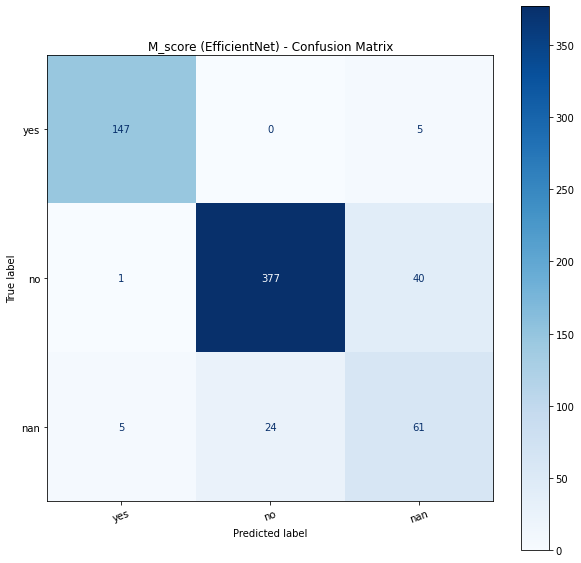

              precision    recall  f1-score   support

         yes       0.96      0.97      0.96       152
          no       0.94      0.90      0.92       418
         nan       0.58      0.68      0.62        90

    accuracy                           0.89       660
   macro avg       0.83      0.85      0.84       660
weighted avg       0.90      0.89      0.89       660



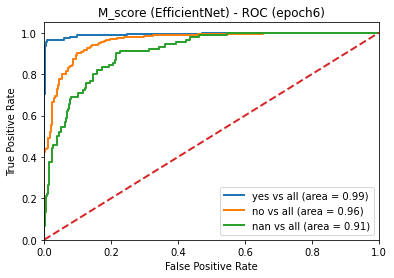

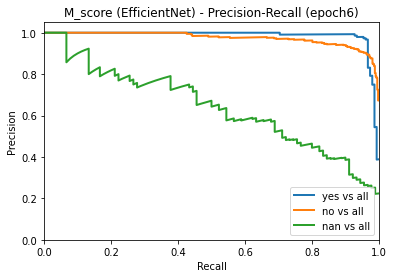

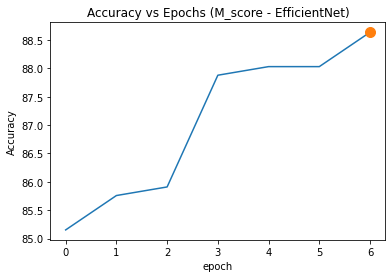

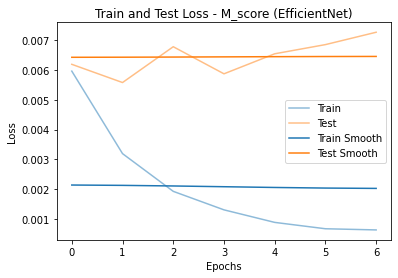

In [ ]:
plot_confusion_matrix(y_test_tot, y_pred, classes, title, CNN)
print(classification_report(y_test_tot, y_pred, target_names=classes))

if len(classes) > 2:
    ova = [0, 1, 2]
else:
    ova = [0]
    
plot_roc_curve(results, title, classes, CNN, ova, idx)
plot_pr_curve(results, title, classes, CNN, ova, idx)
plot_acc_epochs(results, title, CNN)
plot_losses(results, title, CNN)

# ***ViT - VISION TRANSFORMER***
https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/



In [ ]:
list(image_size)

[3, 256, 256]

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
def get_patches(images, n_patches):
  n, c, h, w = images.shape
  patches = torch.zeros(n, n_patches ** 2, c * h * w // n_patches ** 2)
  patch_size = h // n_patches

  for idx, image in enumerate(images):
    for i in range(n_patches):
        for j in range(n_patches):
            patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
            
            patches[idx, i * n_patches + j] = patch.flatten()
  return patches

Second method for patchyfing images: splitting an image into patches and linearly projecting these flattened patches can be simplified as a **single convolution operation**, where both the kernel size and the stride size are set to the patch size.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
      result = []
      for sequence in sequences:
          seq_result = []
          for head in range(self.n_heads):
              q_mapping = self.q_mappings[head]
              k_mapping = self.k_mappings[head]
              v_mapping = self.v_mappings[head]

              seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
              q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

              attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
              seq_result.append(attention @ v)
          result.append(torch.hstack(seq_result))
      return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

## *ViT Model*

In [ ]:
class scratch_ViT (nn.Module):
  def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10, device=None):
    super(scratch_ViT, self).__init__()
    self.device = device

    self.input_shape = input_shape # ( C , H , W )
    self.n_patches = n_patches
    self.n_heads = n_heads
    assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
    self.hidden_d = hidden_d

    # 1) Linear mapper
    self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])

    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    from torch_position_embedding import PositionEmbedding

    PositionEmbedding(num_embeddings=5, embedding_dim=10, mode=PositionEmbedding.MODE_ADD)
    # (In forward method)

    # 4a) Layer normalization 1
    self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))
    # +1 for that special token


    # 4b) Multi-head Self Attention (MSA) and classification token
    self.msa = MyMSA(self.hidden_d, n_heads)

    # 5a) Layer normalization 2
    self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

    # 5b) Encoder MLP
    self.enc_mlp = nn.Sequential(
        nn.Linear(self.hidden_d, self.hidden_d),
        nn.ReLU()
    )

    # 6) Classification MLP
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_d, out_d),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
      # Dividing images into patches
      n, c, w, h = images.shape
      patch_emb = get_patches(images, self.n_patches)
      #patch_emb = PatchEmbedding(list(image_size)[1], list(image_size)[1]/self.n_patches, self.hidden_d)
      # Map the vector corresponding to each patch to the hidden size dimension
      tokens = self.linear_mapper(patch_emb)

      # Adding classification token to the tokens
      tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
      tokens += get_positional_embeddings(
            self.n_patches ** 2 + 1, self.hidden_d).repeat(n, 1, 1).to(self.device)
      out = tokens + self.msa(self.ln1(tokens))
      out = out + self.enc_mlp(self.ln2(out))
      out = out[:, 0]
      return self.mlp(out)

# ***Main ViT***

In [ ]:
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
!pip install pytorch_pretrained_vit

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = None
n_p = 16
h_d = 18
n_h = 9
output = len(classes)  #number of classes

learning_rate = 0.001
epoch_num = 20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import timm
model = scratch_ViT(list(image_size), n_patches=n_p, hidden_d=h_d, n_heads=n_h, out_d=output, device=device).to(device)
#model = torch.load(data_path + 'results/S_score/' + 'best_model_n15.pth')
#from pytorch_pretrained_vit import ViT
#model = ViT('B_16', pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

count_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters} trainable parameters')

predicted_list = []
predicted_list_nm = []
labels_list = []
labels_list_nm =[]
score_list = []
score_list_nm = []

test_acc_list = []
test_loss_list = []
train_loss_list = []
train_acc_list = []
epoch_time_list = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
  start_time = time.monotonic()
  batch_idx = 0
  epoch_acc = 0
  train_loss = 0.0
  model.train()
  for i, batch in enumerate(dataloaders['train'],0):
    #print(batch)
    print(f"Epoch {epoch+1}/{epoch_num} - batch {i+1}/{n/batch_size}")

    x, y = batch
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    y_hat = model(x)
    loss = criterion(y_hat, y) 
    train_loss += loss.detach().cpu().item()

    loss.backward()
    optimizer.step()

    epoch_acc += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item() 
    #print(f'epoch_acc {epoch_acc}')
  train_loss = train_loss / dataset_sizes['train']
  epoch_acc = epoch_acc/ dataset_sizes['train']
  train_loss_list.append(train_loss )
  train_acc_list.append(epoch_acc)
  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  epoch_time_list.append(f'{epoch_mins}m {epoch_secs}s')

  #model.save('saved_model/my_model')
# Test loop
  with torch.no_grad():
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0
    y_true = []     
    y_pred = []
    score = []
    for batch in dataloaders['valid']:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        preds = torch.argmax(y_hat, dim=1)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss.detach().cpu().item()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        y_pred.append(preds.detach().cpu().numpy())
        y_true.append(y.detach().cpu().numpy())
        score.append(y_hat.detach().cpu().numpy())
    
    predicted_list_nm.append(y_pred)
    labels_list_nm.append(y_true)
    score_list_nm.append(score)

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    score = np.concatenate(score)

    predicted_list.append(y_pred)
    labels_list.append(y_true)
    score_list.append(score)

    test_acc_list.append(correct / total * 100)
    test_loss_list.append(test_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.2f} |  Val. Acc: {correct / total*100:.2f}%')

    #if test_acc_list[-1] > 60:
    #  torch.save(model,data_path + 'results/S_score/'+ f'best_model_n{epoch}.pth')

print('Finished Training')
      
  

Output streaming troncato alle ultime 5000 righe.
Epoch 8/20 - batch 241/400.0
Epoch 8/20 - batch 242/400.0
Epoch 8/20 - batch 243/400.0
Epoch 8/20 - batch 244/400.0
Epoch 8/20 - batch 245/400.0
Epoch 8/20 - batch 246/400.0
Epoch 8/20 - batch 247/400.0
Epoch 8/20 - batch 248/400.0
Epoch 8/20 - batch 249/400.0
Epoch 8/20 - batch 250/400.0
Epoch 8/20 - batch 251/400.0
Epoch 8/20 - batch 252/400.0
Epoch 8/20 - batch 253/400.0
Epoch 8/20 - batch 254/400.0
Epoch 8/20 - batch 255/400.0
Epoch 8/20 - batch 256/400.0
Epoch 8/20 - batch 257/400.0
Epoch 8/20 - batch 258/400.0
Epoch 8/20 - batch 259/400.0
Epoch 8/20 - batch 260/400.0
Epoch 8/20 - batch 261/400.0
Epoch 8/20 - batch 262/400.0
Epoch 8/20 - batch 263/400.0
Epoch 8/20 - batch 264/400.0
Epoch 8/20 - batch 265/400.0
Epoch 8/20 - batch 266/400.0
Epoch 8/20 - batch 267/400.0
Epoch 8/20 - batch 268/400.0
Epoch 8/20 - batch 269/400.0
Epoch 8/20 - batch 270/400.0
Epoch 8/20 - batch 271/400.0
Epoch 8/20 - batch 272/400.0
Epoch 8/20 - batch 273

In [ ]:
patches_dimension = (list(image_size)[1] / n_p) **2
test_acc_list = torch.tensor(test_acc_list, device = 'cpu')
test_loss_list =  torch.tensor(test_loss_list, device = 'cpu')
train_loss_list =  torch.tensor(train_loss_list, device = 'cpu')
train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
#print(test_loss_list)
results = pd.DataFrame({'Epoch': list(range(1,len(test_acc_list)+1)),
                        'Patches dimension' : [patches_dimension]*(len(test_acc_list)),
                        'Number of heads': [n_h]*(len(test_acc_list)),
                        'Hidden dimensions': [h_d]*(len(test_acc_list)),
                        'LR': [learning_rate]*(len(test_acc_list)),
                        'Batch size': [batch_size]*(len(test_acc_list)),
                        'Train acc': train_acc_list,
                        'Train loss': train_loss_list,
                        'Test acc': test_acc_list,
                        'Test loss': test_loss_list,
                        'Score': score_list, #y_score
                        'Predicted': predicted_list, #y_pred
                        'Labels': labels_list,
                        'Score nm': score_list_nm, #y_score
                        'Predicted nm': predicted_list_nm, #y_pred
                        'Labels nm': labels_list_nm
                        }) #y_true
torch.save(results, data_path +'results2/C_score/' + 'C_score_ViT_10-01-23.pt')

<ipython-input-116-75afde86a807>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc_list = torch.tensor(test_acc_list, device = 'cpu')
<ipython-input-116-75afde86a807>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss_list =  torch.tensor(test_loss_list, device = 'cpu')
<ipython-input-116-75afde86a807>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss_list =  torch.tensor(train_loss_list, device = 'cpu')
<ipython-input-116-75afde86a807>:5: UserWarning: To copy construct from a tensor, it is recommended to use sou

# ***RESULTS ViT***

In [ ]:
results = torch.load( data_path +'results2/S_score/'+ 'S_score_ViT_09-01-23.pt')
best_test_acc = 0
epoch_num = len(results['Test acc'])
test_acc = results['Test acc']
for i in range(len(test_acc)):
  if test_acc[i] > best_test_acc:
    best_test_acc = test_acc[i]
    idx = i
    #print(idx)

y_score_tot = results['Score'][idx]
y_test_tot = results['Labels'][idx]
y_pred = results['Predicted'][idx]
#model = torch.load(data_path + 'results2/S_score/'+f'best_DenseNet_model_n{idx}.pth')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import RocCurveDisplay


M_score = False
E_score = False
S_score = True
C_score = False


if M_score == True:
  title = 'M_score'
  classes = ['yes', 'no', 'nan'] 
elif E_score == True:
  title = 'E-score'
  classes = ['yes', 'no']
elif S_score == True:
  title = 'S-score'
  classes = ['GGS', 'NoGS', 'SGS']
elif C_score == True:
  classes = ['yes', 'no']
  title = 'C-score'


def plot_confusion_matrix(labels, pred_labels, classes, title):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    plt.title(f'{title} (ViT) - Confusion Matrix')
    plt.show()

def plot_pr_curve(results, title, classes, ova, idx):
    lw = 2

    for i in ova:

      y_score_tot = results['Score'][idx]
      y_test_tot = results['Labels'][idx]
      #y_true = y_true_mc(y_test_tot)
      
      if len(ova) < 2:
        pr,rec, thresholds = precision_recall_curve(y_test_tot, y_score_tot[:, 1])
        pr_auc = auc(rec, pr)
        plt.plot(rec, pr, lw=lw, label=f"yes vs no (area = {round(pr_auc, 2)})")

      else:
         #fpr, tpr, thresholds = roc_curve(y_true[:,i], y_score_tot[:, i], pos_label = 0)
         pr, rec, thresholds = precision_recall_curve(y_test_tot, y_score_tot[:, i], pos_label = i)
         pr_auc = auc(rec, pr)
         plt.plot(rec, pr, lw=lw, label=f"{classes[i]} vs all (area = {round(pr_auc, 2)})")

    no_skill = len(y_test_tot[y_test_tot==1]) / len(y_test_tot)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'{title} (ViT) - Precision-Recall (epoch{idx})')
    plt.legend(loc="lower right")
    plt.show()

#ROC CURVE
def plot_roc_curve(results, title, classes, ova, idx):
    lw = 2

    for i in ova:

      y_score_tot = results['Score'][idx]
      y_test_tot = results['Labels'][idx]
      #y_true = y_true_mc(y_test_tot)
      
      if len(ova) < 2:
        fpr, tpr, thresholds = roc_curve(y_test_tot, y_score_tot[:, 1])
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, lw=lw, label=f"yes vs no (area = {round(roc_auc, 2)})")
      else:
         #fpr, tpr, thresholds = roc_curve(y_true[:,i], y_score_tot[:, i], pos_label = 0)
         fpr, tpr, thresholds = roc_curve(y_test_tot, y_score_tot[:, i], pos_label = i)
         roc_auc = auc(fpr,tpr)
         plt.plot(fpr, tpr, lw=lw, label=f"{classes[i]} vs all (area = {round(roc_auc, 2)})")

    plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} (ViT) - ROC (epoch{idx})')
    plt.legend(loc="lower right")
    plt.show()


#AUC vs epochs
def plot_acc_epochs(results, title):
    acc = results['Test acc'].tolist()
    epochs = list(range(1, epoch_num+1))
    plt.plot(acc)
    plt.plot(acc.index(max(acc)), max(acc), '-o', markersize=10)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs ({title})')
    plt.show()

#Losses
def plot_losses(results, title):
    test_loss = results['Test loss']
    train_loss = results['Train loss']

    plt.plot(train_loss, label='Train', color='tab:blue', alpha=0.5)
    plt.plot(test_loss, label='Test', color='tab:orange', alpha=0.5)
    plt.plot(gaussian_filter1d(train_loss, 6), label='Train Smooth',
             color='tab:blue')
    plt.plot(gaussian_filter1d(test_loss, 6), label='Test Smooth',
             color='tab:orange')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train and Test Loss - {title} (ViT)')
    plt.legend(['Train', 'Test', 'Train Smooth', 'Test Smooth'])
    plt.show()



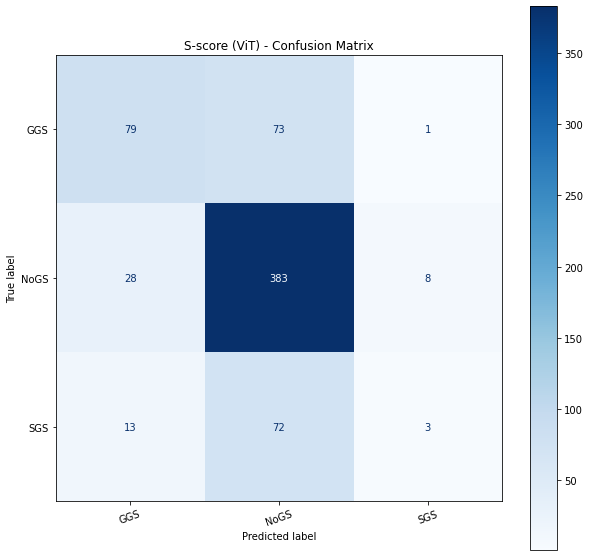

              precision    recall  f1-score   support

         GGS       0.66      0.52      0.58       153
        NoGS       0.73      0.91      0.81       419
         SGS       0.25      0.03      0.06        88

    accuracy                           0.70       660
   macro avg       0.54      0.49      0.48       660
weighted avg       0.65      0.70      0.66       660



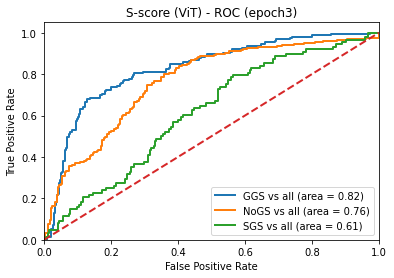

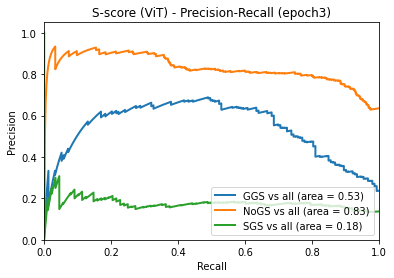

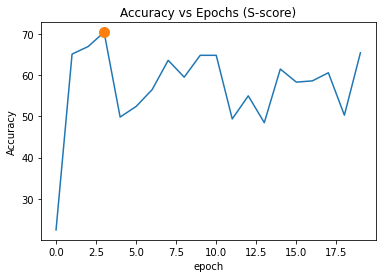

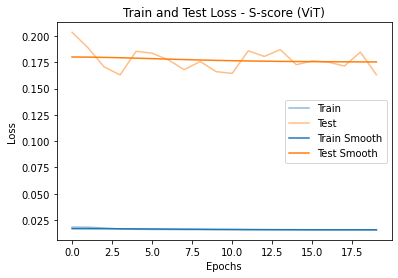

In [ ]:
plot_confusion_matrix(y_test_tot, y_pred, classes, title)
print(classification_report(y_test_tot, y_pred, target_names=classes))
if len(classes) > 2:
    ova = [0, 1, 2]
else:
    ova = [0]

plot_roc_curve(results, title, classes, ova, idx)
plot_pr_curve(results, title, classes, ova, idx)
plot_acc_epochs(results, title)
plot_losses(results, title)

# ***CvT - Convolutions to Vision Transformers***
https://github.com/lucidrains/vit-pytorch

https://github.com/rishikksh20/convolution-vision-transformers

In [ ]:
!pip install einops
from einops.layers.torch import Rearrange
from einops import rearrange, repeat
from torch import nn, einsum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [ ]:
class ConvAttention(nn.Module):
  def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, qkv_strides=[1,1,1], dropout = 0.,
                 last_stage=False):
      super().__init__()
      self.last_stage = last_stage
      self.img_size = img_size
      inner_dim = dim_head *  heads
      project_out = not (heads == 1 and dim_head == dim)

      self.heads = heads
      self.scale = dim_head ** -0.5
      pad = (kernel_size - qkv_strides[0])//2

      self.q = nn.Sequential(nn.Conv2d(dim, inner_dim, kernel_size, qkv_strides[0], pad))
      self.k = nn.Sequential(nn.Conv2d(dim, inner_dim, kernel_size, qkv_strides[1], pad))
      self.v = nn.Sequential(nn.Conv2d(dim, inner_dim, kernel_size, qkv_strides[2], pad))

      if project_out:
        self.out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout))
      else:
        self.out = nn.Identity()

  def forward(self,x):
    b, n, _, h = *x.shape, self.heads
    if self.last_stage:
          cls_token = x[:, 0]
          x = x[:, 1:]
          cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
    x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
    q = self.q(x)
    q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

    v = self.v(x)
    v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

    k = self.k(x)
    k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

    if self.last_stage:
        q = torch.cat((cls_token, q), dim=2)
        v = torch.cat((cls_token, v), dim=2)
        k = torch.cat((cls_token, k), dim=2)


    dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

    attn = dots.softmax(dim=-1)

    out = einsum('b h i j, b h j d -> b h i d', attn, v)
    out = rearrange(out, 'b h n d -> b n (h d)')
    out =  self.out(out)
    return out




In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class myViT(nn.Module):
  def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        self.layers.append(nn.ModuleList([
                PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
  def forward(self,x):
    for ca, ff in self.layers:
      x = ca(x) + x
      x = ff(x) + x
    return x


In [ ]:
  class CvT(nn.Module):
    def __init__(self, image_size, in_channels, num_classes, dim=64, kernels=[7, 3, 3], strides=[4, 2, 2],
                 heads=[1, 3, 6] , depth = [1, 2, 10],pool='cls', dropout=0., emb_dropout=0., scale_dim=4):
      super().__init__()
      assert pool in {'cls','mean'}, 'pool type has to be cls (token) or mean (pooling)'
      self.pool = pool
      self.dim = dim
      self.scale_dim = scale_dim
      ##### Stage 1 #######
      self.stage1_conv_embed = nn.Sequential(
          nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
          Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
          nn.LayerNorm(dim)
      )
      self.stage1_transformer = nn.Sequential(
          myViT(dim=dim, img_size=image_size//4,depth=depth[0], heads=heads[0], dim_head=self.dim,
                                            mlp_dim=dim * scale_dim, dropout=dropout),
          Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
      )

      ##### Stage 2 #######
      in_channels = dim
      scale = heads[1]//heads[0]
      dim = scale*dim
      self.stage2_conv_embed = nn.Sequential(
          nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
          Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
          nn.LayerNorm(dim)
      )
      self.stage2_transformer = nn.Sequential(
          myViT(dim=dim, img_size=image_size//8, depth=depth[1], heads=heads[1], dim_head=self.dim,
                                            mlp_dim=dim * scale_dim, dropout=dropout),
          Rearrange('b (h w) c -> b c h w', h = image_size//8, w = image_size//8)
      )

      ##### Stage 3 #######
      in_channels = dim
      scale = heads[2] // heads[1]
      dim = scale * dim
      self.stage3_conv_embed = nn.Sequential(
          nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
          Rearrange('b c h w -> b (h w) c', h = image_size//16, w = image_size//16),
          nn.LayerNorm(dim)
      )
      self.stage3_transformer = nn.Sequential(
          myViT(dim=dim, img_size=image_size//16, depth=depth[2], heads=heads[2], dim_head=self.dim,
                                            mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
      )


      self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
      self.dropout_large = nn.Dropout(emb_dropout)


      self.mlp_head = nn.Sequential(
          nn.LayerNorm(dim),
          nn.Linear(dim, num_classes)
      )

    def forward(self, img):

        xs = self.stage1_conv_embed(img)
        xs = self.stage1_transformer(xs)

        xs = self.stage2_conv_embed(xs)
        xs = self.stage2_transformer(xs)

        xs = self.stage3_conv_embed(xs)
        b, n, _ = xs.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs = torch.cat((cls_tokens, xs), dim=1)
        xs = self.stage3_transformer(xs)
        xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

        xs = self.mlp_head(xs)
        return xs

## ***MAIN***

### **Learning rate finder**

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
!pip install torch-lr-finder -v --global-option="apex"
from torch_lr_finder import LRFinder

img_size = image_size[1]
input_channels = image_size[0]
if C_score == True:
  num_classes = 2
elif M_score==True:
  num_classes = 3
dim = 64 
kernels = [7, 3, 3]
strides = [4, 2, 2]
heads = [1, 3, 6]
depth = [1, 2, 10]
dropout = 0.0
model = CvT(img_size, input_channels, num_classes, dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=None)
lr_finder.range_test(dataloaders['train'], end_lr=50, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## ***Training***

In [ ]:
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

epoch_num = 8
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")

img_size = image_size[1]
input_channels = image_size[0]
if C_score == True:
  num_classes = 2
elif M_score==True:
  num_classes = 3
dim = 64 
kernels = [7, 3, 3]
strides = [4, 2, 2]
heads = [1, 3, 6]
depth = [1, 2, 10]
dropout = 0.0
model = CvT(img_size, input_channels, num_classes, dim)
model.to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)

count_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters} trainable parameters')


The model has 7574915 trainable parameters


In [ ]:
test_accuracy_list = []
test_loss_list = []
train_accuracy_list = []
train_loss_list = []
epoch_time_list = []

for epoch in range(epoch_num):

  start_time = time.monotonic()
  model.train()
  epoch_loss = 0
  epoch_acc = 0
  batch_idx = 0
  for i, data in enumerate(dataloaders['train']):

    print(f"Epoch {epoch+1}/{epoch_num} - batch {batch_idx+1}/{n/batch_size}")
    batch_idx += 1

    inputs, target = data
    inputs, target = inputs.to(device), target.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, target) / len(inputs)
    train_loss = loss.detach().cpu().item()

    loss.backward()
    optimizer.step()
    
    train_acc = (torch.sum(preds == target.data))
    epoch_acc += train_acc.item() 
    epoch_loss += train_loss 


  epoch_acc = epoch_acc.double() / dataset_sizes['train']

  print(f"Train loss: {epoch_loss:.3f}")
  print(f"Train accuracy: {epoch_acc*100:.3f}%\n")
  
  train_loss_list.append(epoch_loss)
  train_accuracy_list.append(epoch_acc * 100)

  with torch.no_grad():
    epoch_val_acc = 0
    epoch_val_loss = 0

    batch_val_idx = 0
    model.eval()

    for data in dataloaders['valid']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        val_outputs = model(images)
        _, predicted = torch.max(val_outputs.data, 1)

        val_loss = criterion(val_outputs, labels) / len(images)
        valid_loss = val_loss.detach().cpu().item()
        epoch_val_loss += valid_loss

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #val_acc = (torch.argmax(val_output, dim=1) == labels).detach().cpu().float().mean()
    epoch_val_acc = correct / total 
    
    test_accuracy_list.append(epoch_val_acc * 100)
    test_loss_list.append(epoch_val_loss)

  print(f"Test loss: {epoch_val_loss:.3f}")
  print(f"Test accuracy: {epoch_val_acc * 100:.3f}%\n")
  #print(f"Epoch {epoch + 1}/{epoch_num}")

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  epoch_time_list.append(f'{epoch_mins}m {epoch_secs}s')
  print(f"{epoch_mins}m {epoch_secs}s")
    

In [ ]:
results = pd.DataFrame({'Epoch': list(range(1,epoch_num+1)),
                     'LR': [learning_rate]*(epoch_num),
                     'Batch size': [batch_size]*(epoch_num),
                     'Train acc': train_accuracy_list,
                     'Train loss': train_loss_list,
                     'Test acc': test_accuracy_list,
                     'Test loss': test_loss_list})
torch.save(results, data_path + 'M_score_CvT_13-10-22.pt')

In [ ]:
results = torch.load(data_path + 'M_score_CvT_no_norm_zgafter.pt')


In [ ]:
train_accuracy_list = list(results['Train acc'])
train_loss_list = list(results['Train loss'])

test_accuracy_list = list(results['Test acc'])
test_loss_list = list(results['Test loss'])

In [ ]:
len(images)

25

## ***PLOT ACCURACY***

In [ ]:
plt.plot(train_acc_list,'-o')
plt.plot(test_acc_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy - DenseNet (M-score)')

plt.show()

## ***PLOT LOSSES***

In [ ]:
plt.plot(train_loss_list,'-o')
plt.plot(test_loss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses - DenseNet (M-score)')

plt.show()

In [ ]:
test_acc_list

[0, 0, 0]

  PLOT ALEXNET

In [ ]:
train_acc=torch.stack(train_acc_list)
plt.plot(train_acc.tolist(),'-o')
plt.plot(test_acc_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [ ]:
plt.plot(train_loss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

### First attempt

In [ ]:
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

epoch_nume = 8
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)
img_size = image_size[1]
input_channels = image_size[0]
if C_score == True:
  num_classes = 2
elif M_score==True:
  num_classes = 3
dim = 64 
kernels = [7, 3, 3]
strides = [4, 2, 2]
heads = [1, 3, 6]
depth = [1, 2, 10]
dropout = 0.0
model = CvT(img_size, input_channels, num_classes, dim)
model.to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

count_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters} trainable parameters')

test_accuracy_list = []
test_loss_list = []
train_loss_list = []
epoch_time_list = []

for epoch in range(epoch_num):
  start_time = time.monotonic()
  train_loss = 0.0
  batch_num = 0
  for batch in dataloaders['train']:
    batch_num +=1
    print(f"Epoch {epoch+1}/{epoch_num} - batch {batch_num}/{n/batch_size}")
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    optimizer.zero_grad()
    loss = criterion(y_hat, y) / len(dataloaders['train'])
    train_loss += loss.detach().cpu().item()

    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch + 1}/{epoch_num} loss: {train_loss:.2f}")
  train_loss_list.append(train_loss)
  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  epoch_time_list.append(f'{epoch_mins}m {epoch_secs}s')

  # Test loop
with torch.no_grad():

  correct, total = 0, 0
  test_loss = 0.0
  for batch in dataloaders['valid']:
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = criterion(y_hat, y) / len(dataloaders['valid'])
      test_loss += loss.detach().cpu().item()

      correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
      total += len(dataloaders['valid'])
  test_accuracy_list.append(correct / total * 100)
  test_loss_list.append(test_loss)
  print(f"Test loss: {test_loss:.2f}")
  print(f"Test accuracy: {correct / total * 100:.2f}%")